# Lab 2: Classification

### Machine Learning 1, September 2016

* The lab exercises should be made in groups of two people.
* The deadline is October 9th (Sunday) 23:59.
* Assignment should be sent to your teaching assistant. The subject line of your email should be "lab\#\_lastname1\_lastname2\_lastname3".
* Put your and your teammates' names in the body of the email.
* Attach the .IPYNB (IPython Notebook) file containing your code and answers. Naming of the file follows the same rule as the subject line. For example, if the subject line is "lab01\_Kingma\_Hu", the attached file should be "lab01\_Kingma\_Hu.ipynb". Only use underscores ("\_") to connect names, otherwise the files cannot be parsed.

Notes on implementation:

* For this notebook you need to answer a few theory questions, add them in the Markdown cell's below the question. Note: you can use Latex-style code in here.
* Focus on Part 1 the first week, and Part 2 the second week!
* You should write your code and answers below the questions in this IPython Notebook.
* Among the first lines of your notebook should be "%pylab inline". This imports all required modules, and your plots will appear inline.
* If you have questions outside of the labs, post them on blackboard or email me.
* NOTE: Make sure we can run your notebook / scripts!

$\newcommand{\bx}{\mathbf{x}}$
$\newcommand{\bw}{\mathbf{w}}$
$\newcommand{\bt}{\mathbf{t}}$
$\newcommand{\by}{\mathbf{y}}$
$\newcommand{\bm}{\mathbf{m}}$
$\newcommand{\bb}{\mathbf{b}}$
$\newcommand{\bS}{\mathbf{S}}$
$\newcommand{\ba}{\mathbf{a}}$
$\newcommand{\bz}{\mathbf{z}}$
$\newcommand{\bv}{\mathbf{v}}$
$\newcommand{\bq}{\mathbf{q}}$
$\newcommand{\bp}{\mathbf{p}}$
$\newcommand{\bh}{\mathbf{h}}$
$\newcommand{\bI}{\mathbf{I}}$
$\newcommand{\bX}{\mathbf{X}}$
$\newcommand{\bT}{\mathbf{T}}$
$\newcommand{\bPhi}{\mathbf{\Phi}}$
$\newcommand{\bW}{\mathbf{W}}$
$\newcommand{\bV}{\mathbf{V}}$

In [5]:
%pylab inline
import gzip, cPickle
from sklearn.metrics import mean_squared_error

Populating the interactive namespace from numpy and matplotlib


In [6]:
# HELPER FUNCTIONS

def rmse(prd,t):
    """ Calculates the root mean squared error between predictions and target values """
    rms = np.sqrt(mean_squared_error(t, prd))
    return rms


def softmax(z):
    ''' Compute softmax , implementing with the log-sum-exp trick'''
    return np.exp(z-np.max(z))/np.sum(np.exp(z-np.max(z)))


def sigmoid(z):
    ''' Sigmoid function (without logsumexp)'''
    return 1/(1+np.exp(-z))


def dwsigmoid(z):
    ''' 1st order derivative of the sigmoid '''
    return sigmoid(z)*(1-sigmoid(z))


def cost(inpt,outpt,w,b):
    s = calculate_log_q(inpt, outpt, w, b)
    cost = outpt*np.log(s)+(1-outpt)*np.log(1-s) 
    return cost


def calc_logq(inpt,w,b):
    ''' dot product calculation'''
    a = np.dot(inpt,w) + b.T       
    return a

def calc_logz(log_q):
    ''' Normalization constant '''
    a = np.max(log_q)
    Z = np.sum(exp(log_q-a))
    return a + np.log(Z)

def calc_logp(log_q,log_Z):
    ''' Calculate normalized log-likelihood '''
    return log_q-log_Z

# Part 1. Multiclass logistic regression

Scenario: you have a friend with one big problem: she's completely blind. You decided to help her: she has a special smartphone for blind people, and you are going to develop a mobile phone app that can do _machine vision_ using the mobile camera: converting a picture (from the camera) to the meaning of the image. You decide to start with an app that can read handwritten digits, i.e. convert an image of handwritten digits to text (e.g. it would enable her to read precious handwritten phone numbers).

A key building block for such an app would be a function `predict_digit(x)` that returns the digit class of an image patch $\bx$. Since hand-coding this function is highly non-trivial, you decide to solve this problem using machine learning, such that the internal parameters of this function are automatically learned using machine learning techniques.

The dataset you're going to use for this is the MNIST handwritten digits dataset (`http://yann.lecun.com/exdb/mnist/`). You can load the data from `mnist.pkl.gz` we provided, using: 

In [7]:
def load_mnist():
    f = gzip.open('mnist.pkl.gz', 'rb')
    data = cPickle.load(f)
    f.close()
    return data

(x_train, t_train), (x_valid, t_valid), (x_test, t_test) = load_mnist()

# shuffle data sets
idx = np.arange(0,x_train.shape[0])
np.random.shuffle(idx)

x_shuffle = x_train[idx]
t_shuffle = t_train[idx]


The tuples represent train, validation and test sets. The first element (`x_train`, `x_valid`, `x_test`) of each tuple is a $N \times M$ matrix, where $N$ is the number of datapoints and $M = 28^2 = 784$ is the dimensionality of the data. The second element (`t_train`, `t_valid`, `t_test`) of each tuple is the corresponding $N$-dimensional vector of integers, containing the true class labels.

Here's a visualisation of the first 8 digits of the trainingset:

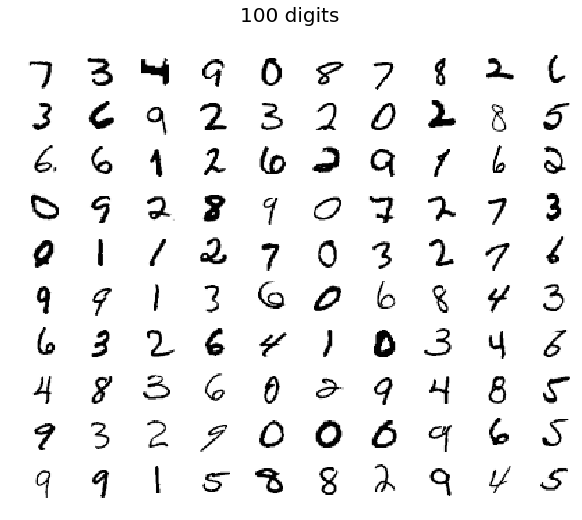

In [8]:
def plot_digits(data, numcols, shape=(28,28)):
    numdigits = data.shape[0]
    pylab.rcParams['figure.figsize'] = (10, 8)
    numrows = int(numdigits/numcols)
    for i in range(numdigits):
        plt.subplot(numrows, numcols, i+1)
        plt.axis('off')
        plt.imshow(data[i].reshape(shape), interpolation='nearest', cmap='Greys')
    plt.suptitle("%u digits"%(numdigits),fontsize=20)
    plt.show()
    
    
plot_digits(x_shuffle[0:100,:], numcols=10)

In _multiclass_ logistic regression, the conditional probability of class label $j$ given the image $\bx$ for some datapoint is given by:

$ \log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $\log q_j = \bw_j^T \bx + b_j$ (the log of the unnormalized probability of the class $j$), and $Z = \sum_k q_k$ is the normalizing factor. $\bw_j$ is the $j$-th column of $\bW$ (a matrix of size $784 \times 10$) corresponding to the class label, $b_j$ is the $j$-th element of $\bb$.

Given an input image, the multiclass logistic regression model first computes the intermediate vector $\log \bq$ (of size $10 \times 1$), using $\log q_j = \bw_j^T \bx + b_j$, containing the unnormalized log-probabilities per class. 

The unnormalized probabilities are then normalized by $Z$ such that $\sum_j p_j = \sum_j \exp(\log p_j) = 1$. This is done by $\log p_j = \log q_j - \log Z$ where $Z = \sum_j \exp(\log q_j)$. This is known as the _softmax_ transformation, and is also used as a last layer of many classifcation neural network models, to ensure that the output of the network is a normalized distribution, regardless of the values of second-to-last layer ($\log \bq$)

Warning: when computing $\log Z$, you are likely to encounter numerical problems. Save yourself countless hours of debugging and learn the [log-sum-exp trick](https://hips.seas.harvard.edu/blog/2013/01/09/computing-log-sum-exp/ "Title").

The network's output $\log \bp$ of size $10 \times 1$ then contains the conditional log-probabilities $\log p(t = j \;|\; \bx, \bb, \bW)$ for each digit class $j$. In summary, the computations are done in this order:

$\bx \rightarrow \log \bq \rightarrow Z \rightarrow \log \bp$

Given some dataset with $N$ independent, identically distributed datapoints, the log-likelihood is given by:

$ \mathcal{L}(\bb, \bW) = \sum_{n=1}^N \mathcal{L}^{(n)}$

where we use $\mathcal{L}^{(n)}$ to denote the partial log-likelihood evaluated over a single datapoint. It is important to see that the log-probability of the class label $t^{(n)}$ given the image, is given by the $t^{(n)}$-th element of the network's output $\log \bp$, denoted by $\log p_{t^{(n)}}$:

$\mathcal{L}^{(n)} = \log p(t = t^{(n)} \;|\; \bx = \bx^{(n)}, \bb, \bW) = \log p_{t^{(n)}} = \log q_{t^{(n)}} - \log Z^{(n)}$

where $\bx^{(n)}$ and $t^{(n)}$ are the input (image) and class label (integer) of the $n$-th datapoint, and $Z^{(n)}$ is the normalizing constant for the distribution over $t^{(n)}$.


## 1.1 Gradient-based stochastic optimization

### 1.1.1 Derive gradient equations (20 points)

Derive the equations for computing the (first) partial derivatives of the log-likelihood w.r.t. all the parameters, evaluated at a _single_ datapoint $n$.

You should start deriving the equations for $\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$ for each $j$. For clarity, we'll use the shorthand $\delta^q_j = \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}$.

For $j = t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log p_j}
\frac{\partial \log p_j}{\partial \log q_j}
+ \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= 1 \cdot 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= 1 - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

For $j \neq t^{(n)}$:
$
\delta^q_j
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log Z}
\frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j} 
= - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
$

Complete the above derivations for $\delta^q_j$ by furtherly developing $\frac{\partial \log Z}{\partial Z}$ and $\frac{\partial Z}{\partial \log q_j}$. Both are quite simple. For these it doesn't matter whether $j = t^{(n)}$ or not.

Given your equations for computing the gradients $\delta^q_j$ it should be quite straightforward to derive the equations for the gradients of the parameters of the model, $\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}}$ and $\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}$. The gradients for the biases $\bb$ are given by:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial b_j}
= \frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial b_j}
= \delta^q_j
\cdot 1
= \delta^q_j
$

The equation above gives the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element of $\bb$, so the vector $\nabla_\bb \mathcal{L}^{(n)}$ with all derivatives of $\mathcal{L}^{(n)}$ w.r.t. the bias parameters $\bb$ is: 

$
\nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q
$

where $\mathbf{\delta}^q$ denotes the vector of size $10 \times 1$ with elements $\mathbf{\delta}_j^q$.

The (not fully developed) equation for computing the derivative of $\mathcal{L}^{(n)}$ w.r.t. a single element $W_{ij}$ of $\bW$ is:

$
\frac{\partial \mathcal{L}^{(n)}}{\partial W_{ij}} =
\frac{\partial \mathcal{L}^{(n)}}{\partial \log q_j}
\frac{\partial \log q_j}{\partial W_{ij}}
= \mathbf{\delta}_j^q
\frac{\partial \log q_j}{\partial W_{ij}}
$

What is $\frac{\partial \log q_j}{\partial W_{ij}}$? Complete the equation above.

If you want, you can give the resulting equation in vector format ($\nabla_{\bw_j} \mathcal{L}^{(n)} = ...$), like we did for $\nabla_\bb \mathcal{L}^{(n)}$.

#####Answer: 

* $\frac{\partial \log Z}{\partial Z} = \frac{1}{Z}$


* $\frac{\partial Z}{\partial \log q_j} = \frac{\partial (\sum_j \exp(\log q_j))}{\partial \log q_j} = \exp(\log q_j) = q_j $


* $\frac{\partial \log q_j}{\partial W_{ij}} = \frac{\partial (\bw_{ij}^T \bx_{i} + b_j)}{\partial W_{ij}} = \bx_{i} $


Hence, the partial derivatives of the log-likelihood w.r.t. to all the parameters are

* $ \nabla_\bb \mathcal{L}^{(n)} = \mathbf{\delta}^q 
= [j = t^{(n)}] - \frac{\partial \log Z}{\partial Z} 
\frac{\partial Z}{\partial \log q_j}
= [j = t^{(n)}] - (\frac{1}{Z}) * (q_j)
= [j = t^{(n)}] - \frac{q_j}{Z}
= [j = t^{(n)}] - p_j
$


* $\nabla_{\bw_j} \mathcal{L}^{(n)} 
= \mathbf{\delta}^q \frac{\partial \log q_j}{\partial W_{ij}}
= \left([j = t^{(n)}] -  p_j \right) \mathbf{x}^{(n)}
$



### 1.1.2 Implement gradient computations (10 points)

Implement the gradient calculations you derived in the previous question. Write a function `logreg_gradient(x, t, w, b)` that returns the gradients $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (for each $j$) and $\nabla_{\bb} \mathcal{L}^{(n)}$, i.e. the first partial derivatives of the log-likelihood w.r.t. the parameters $\bW$ and $\bb$, evaluated at a single datapoint (`x`, `t`).
The computation will contain roughly the following intermediate variables:

$
\log \bq \rightarrow Z \rightarrow \log \bp\,,\, \mathbf{\delta}^q
$

followed by computation of the gradient vectors $\nabla_{\bw_j} \mathcal{L}^{(n)}$ (contained in a $784 \times 10$ matrix) and $\nabla_{\bb} \mathcal{L}^{(n)}$ (a $10 \times 1$ vector).


In [9]:
def logreg_gradient(x,t,w,b):
    ''' Compute gradients for bias and weights '''
    # Follow steps for getting log-likelihood
    logq = calc_logq(x,w,b)
    logz = calc_logz(logq)
    logp = calc_logp(logq,logz)
    
    # Arrays for gradients
    nablaB = np.zeros(b.shape)
    nablaW = np.zeros(w.shape)
    
    # Calculate gradient over bias
    for j in range(b.shape[0]):
        # Calculate p_j
        p_j = np.exp(logq[:,j]-logz)
        
        if j == t:
            nablaB[j] = 1 - p_j
        else:
            nablaB[j] = - p_j
   
    # Calculate gradient over weights
    x = np.reshape(x,(-1,1))
    nablaW = nablaB.dot(x.T)
    
    return nablaB,nablaW,logp


# TEST FUNCTION
tmp = np.random.randint(10,size=(1,784))
tmpb = np.random.randint(10,size=(10,1))
tmpw = np.random.randint(10,size=(784,10))
tmpt = 3

lb,lw,lp = logreg_gradient(tmp,tmpt,tmpw,tmpb)


### 1.1.3 Stochastic gradient descent (10 points)

Write a function `sgd_iter(x_train, t_train, w, b)` that performs one iteration of stochastic gradient descent (SGD), and returns the new weights. It should go through the trainingset once in randomized order, call `logreg_gradient(x, t, w, b)` for each datapoint to get the gradients, and update the parameters using a small learning rate (e.g. `1E-4`). Note that in this case we're maximizing the likelihood function, so we should actually performing gradient ___ascent___... For more information about SGD, see Bishop 5.2.4 or an online source (i.e. https://en.wikipedia.org/wiki/Stochastic_gradient_descent)

In [10]:
def sgd_iter(x_train, t_train, w, b, eta):
    ''' Calculate new parameters based on gradients '''
    logps = []
    
    # Iterate through all x_train
    for i in range(x_train.shape[0]):
        db, dw,logp = logreg_gradient(x_train[i],t_train[i],w,b)
        #print db.shape
        
        # Save log-lokelihood for this sample
        logps.append(logp)
       
        # Calculate new weights and bias
        w += eta*dw.T
        b += eta*db  
        
    return w, b, logps

## 1.2. Train

### 1.2.1 Train (10 points)
Perform a handful of training iterations through the trainingset. Plot (in one graph) the conditional log-probability of the trainingset and validation set after each iteration.


In [11]:
def predict(x,w,b):
    """Compute loglikelihood and select the class with highest probability"""
    # Loglikelihood
    logq = calc_logq(x,w,b)
    logz = calc_logz(logq)
    logp = calc_logp(logq,logz)
    
    # Prediction and its probability
    prediction = np.argmax(logp, axis = 1)
    prediction_probability = np.amax(logp, axis=1)

    return prediction, prediction_probability


def correct_class_probability(x,w,b,t):
    """Compute loglikelihood and select the probability for prediction the correct class"""
    # Loglikelihood
    logq = calc_logq(x,w,b)
    logz = calc_logz(logq)
    logp = calc_logp(logq,logz)
    
    # Select logp of correct class
    # correct_probability = np.take(logp, t, axis=1)
    correct_probability = np.zeros(x.shape[0])
    for n in range(x.shape[0]):
        t_temp = t[n]
        logp_temp = logp[n]
        
        correct_probability[n] = logp_temp[t_temp]

    return correct_probability

In [12]:
# INPUT DETAILS
img_shape = (28,28)
num_classes = np.max(t_train)+1
num_dims = x_train.shape[1]
sigma = 0.01

# INITIALIZE RANDOM WEIGHTS AND BIAS
#b = np.random.normal(0,np.ones(num_classes)*sigma)
#b = np.reshape(b,(-1,1))
#w = np.random.normal(0,np.ones((num_dims,num_classes))*sigma)
b = np.zeros((num_classes,1))
w = np.zeros((num_dims,num_classes))
# MODEL PARAMETERS
maxiter = 10
eta = 10**-4          # learning rate
print "eta:  \t%0.5f"%(eta)

rmse_error = np.zeros(maxiter)
ypreds = np.zeros(x_shuffle.shape[0])
logp_correct = np.zeros((maxiter, 2))

# HANDFUL OF TRAINING ITERATIONS
for i in range(maxiter):    
    # make predictions with current weights
    ypreds, _, = predict(x_shuffle,w,b)
    
    # update weights, bias and get likelihood
    w, b,logp_train = sgd_iter(x_shuffle, t_shuffle, w, b, eta)
    _, _, logp_valid = sgd_iter(x_valid, t_valid, w, b, eta)
   
    # calculate error of predictions
    rmse_error[i] = rmse(ypreds,t_shuffle)
    
    # get the probability of correct classes
    logprobability_correct_train = correct_class_probability(x_shuffle,w,b,t_shuffle)
    logprobability_correct_valid = correct_class_probability(x_valid,w,b,t_valid)
    
    # save loglikelihoods
    logp_correct[i] = (np.mean(logprobability_correct_train), np.mean(logprobability_correct_valid))
    print "iteration: \t%d, rmse error: \t%0.8f mean loglikelihood training: \t%0.8f mean loglikelihood validation: \t%0.8f"%(i+1, rmse_error[i], logp_correct[i][0], logp_correct[i][1])
    #print "iteration: ", i, " eta: ", eta, " rmse error:", rmse_error[i], " mean loglikelihood: ", logp_correct[i]

eta:  	0.00010
iteration: 	1, rmse error: 	5.30580814 mean loglikelihood training: 	-11.87579724 mean loglikelihood validation: 	-10.20045640
iteration: 	2, rmse error: 	1.70282706 mean loglikelihood training: 	-12.09934457 mean loglikelihood validation: 	-10.39547065
iteration: 	3, rmse error: 	1.58583732 mean loglikelihood training: 	-12.33821110 mean loglikelihood validation: 	-10.61560774
iteration: 	4, rmse error: 	1.51631131 mean loglikelihood training: 	-12.54908492 mean loglikelihood validation: 	-10.81509689
iteration: 	5, rmse error: 	1.47659744 mean loglikelihood training: 	-12.73426720 mean loglikelihood validation: 	-10.99401950
iteration: 	6, rmse error: 	1.44697616 mean loglikelihood training: 	-12.89890287 mean loglikelihood validation: 	-11.15596285
iteration: 	7, rmse error: 	1.42322872 mean loglikelihood training: 	-13.04723421 mean loglikelihood validation: 	-11.30410278
iteration: 	8, rmse error: 	1.40662006 mean loglikelihood training: 	-13.18244805 mean loglikeli

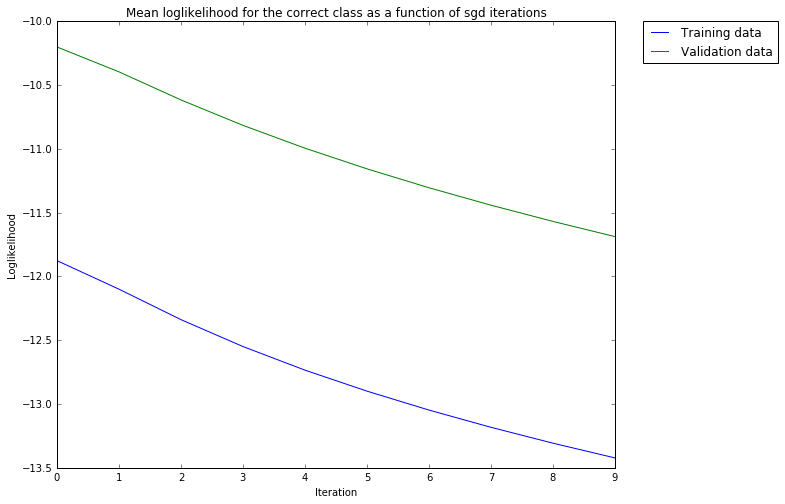

In [13]:
# PLOT
plt.plot(logp_correct[:, 0], label='Training data')
plt.plot(logp_correct[:, 1], label='Validation data')

plt.xlabel('Iteration')
plt.ylabel('Loglikelihood')
plt.title('Mean loglikelihood for the correct class as a function of sgd iterations')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

plt.show()

### 1.2.2 Visualize weights (10 points)
Visualize the resulting parameters $\bW$ after a few iterations through the training set, by treating each column of $\bW$ as an image. If you want, you can use or edit the `plot_digits(...)` above.

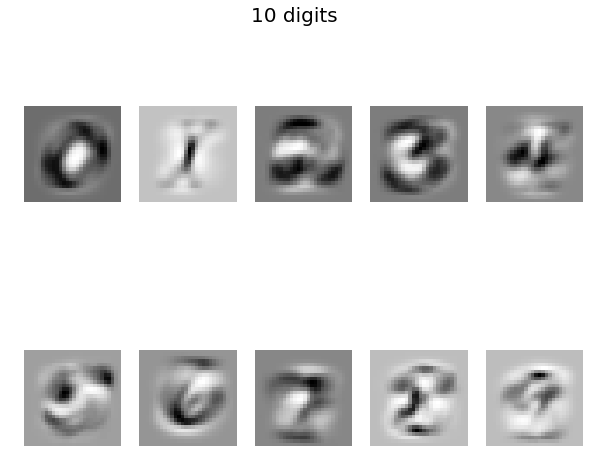

In [14]:
plot_digits(np.transpose(w), numcols=5)

### 1.2.3. Visualize the 8 hardest and 8 easiest digits (10 points)
Visualize the 8 digits in the validation set with the highest probability of the true class label under the model.
Also plot the 8 digits that were assigned the lowest probability.
Ask yourself if these results make sense.

Highest probability of true class:  [-4.47091985 -4.45579794 -4.31465045 -4.27189982 -4.17499836 -3.77726104
 -3.47421483 -2.73439038]


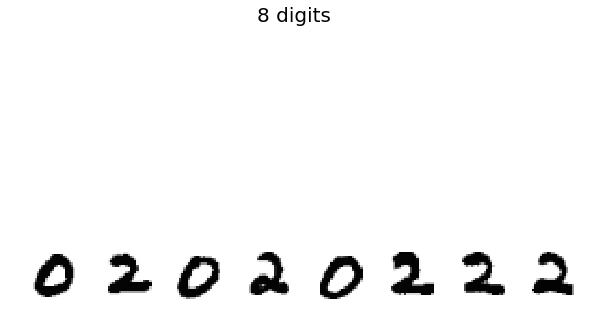

Lowest probability of true class:  [-21.2846225  -20.73310061 -20.72952075 -20.69355085 -20.21432203
 -20.16785623 -20.02014459 -19.75301333]


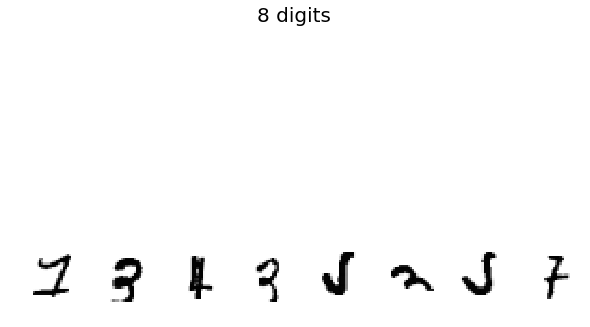

In [15]:
# get the probability of correct classes
logprobability_correct_valid = correct_class_probability(x_valid,w,b,t_valid)

# Sort by probability
sorting_idx = np.argsort(logprobability_correct_valid)
sorted_logp = logprobability_correct_valid[sorting_idx]
sorted_digits = x_valid[sorting_idx]

# Select hardest
easiest_digits = sorted_digits[-8:]
easiest_logp = sorted_logp[-8:]
print "Highest probability of true class: ", easiest_logp
plot_digits(easiest_digits, numcols=8)

# Select easiest
hardest_digits = sorted_digits[0:8]
hardest_logp = sorted_logp[0:8]
print "Lowest probability of true class: ", hardest_logp
plot_digits(hardest_digits, numcols=8)

# Part 2. Multilayer perceptron


You discover that the predictions by the logistic regression classifier are not good enough for your application: the model is too simple. You want to increase the accuracy of your predictions by using a better model. For this purpose, you're going to use a multilayer perceptron (MLP), a simple kind of neural network. The perceptron wil have a single hidden layer $\bh$ with $L$ elements. The parameters of the model are $\bV$ (connections between input $\bx$ and hidden layer $\bh$), $\ba$ (the biases/intercepts of $\bh$), $\bW$ (connections between $\bh$ and $\log q$) and $\bb$ (the biases/intercepts of $\log q$.

The conditional probability of the class label $j$ is given by:

$\log p(t = j \;|\; \bx, \bb, \bW) = \log q_j - \log Z$

where $q_j$ are again the unnormalized probabilities per class, and $Z = \sum_j q_j$ is again the probability normalizing factor. Each $q_j$ is computed using:

$\log q_j = \bw_j^T \bh + b_j$

where $\bh$ is a $L \times 1$ vector with the hidden layer activations (of a hidden layer with size $L$), and $\bw_j$ is the $j$-th column of $\bW$ (a $L \times 10$ matrix). Each element of the hidden layer is computed from the input vector $\bx$ using:

$h_j = \sigma(\bv_j^T \bx + a_j)$

where $\bv_j$ is the $j$-th column of $\bV$ (a $784 \times L$ matrix), $a_j$ is the $j$-th element of $\ba$, and $\sigma(.)$ is the so-called sigmoid activation function, defined by:

$\sigma(x) = \frac{1}{1 + \exp(-x)}$

Note that this model is almost equal to the multiclass logistic regression model, but with an extra 'hidden layer' $\bh$. The activations of this hidden layer can be viewed as features computed from the input, where the feature transformation ($\bV$ and $\ba$) is learned.

## 2.1 Derive gradient equations (20 points)

State (shortly) why $\nabla_{\bb} \mathcal{L}^{(n)}$ is equal to the earlier (multiclass logistic regression) case, and why $\nabla_{\bw_j} \mathcal{L}^{(n)}$ is almost equal to the earlier case.

Like in multiclass logistic regression, you should use intermediate variables $\mathbf{\delta}_j^q$. In addition, you should use intermediate variables $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h_j}$.

Given an input image, roughly the following intermediate variables should be computed:

$
\log \bq \rightarrow Z \rightarrow \log \bp \rightarrow \mathbf{\delta}^q \rightarrow \mathbf{\delta}^h
$

where $\mathbf{\delta}_j^h = \frac{\partial \mathcal{L}^{(n)}}{\partial \bh_j}$.

Give the equations for computing $\mathbf{\delta}^h$, and for computing the derivatives of $\mathcal{L}^{(n)}$ w.r.t. $\bW$, $\bb$, $\bV$ and $\ba$. 

You can use the convenient fact that $\frac{\partial}{\partial x} \sigma(x) = \sigma(x) (1 - \sigma(x))$.

#####Answer: 

* $\nabla_{\bb} \mathcal{L}^{(n)}$ stays the same because the variable $\mathbf{b}$ is independent of all other parameters. $\nabla_{\bw_j} \mathcal{L}^{(n)}$ only changes its dependency from $\mathbf{x}$ to $\mathbf{h}$. Hence, the $\mathbf{x}$'s are switched with $\mathbf{h}$'s.


* Derivatives

Let $\mathbf{W}$ be defined as: 

$\mathbf{W}$ = $\begin{bmatrix}
| & | & | \\ 
\mathbf{w}_1 & \dots & \mathbf{w}_j \\ 
| & | & | 
\end{bmatrix}$


#### 1.
$\delta^h_{ij} = \frac{\partial \mathcal{L}^{(n)}}{\log q_j}  \frac{\log q_j}{\partial h_i} = \delta^q_j \cdot \mathbf{W}_{ij}$



$\delta^h_i = \frac{\partial \mathcal{L}^{(n)}}{\partial h_i} = {\mathbf{W}_i} \cdot \delta^q$



$\delta^h = \frac{\partial \mathcal{L}^{(n)}}{\partial h} = \mathbf{W} \cdot \delta^q$

#### 2.
$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{w_j}} = \delta^q_j \mathbf{h}$



$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{W}} = \mathbf{h} \cdot {\delta^q}^T$



#### 3.
$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{b}} = \delta^q$


#### 4.
$\frac{\partial \mathcal{L}^{(n)}}{\partial \mathbf{v}_j} = \delta^h_j \sigma(\mathbf{v}_j^T \mathbf{x} + \alpha_j) \cdot (1 - \sigma(\mathbf{v}_j^T \mathbf{x} + \alpha_j)) \mathbf{x}$


#### 5.
$\frac{\partial \mathcal{L}^{(n)}}{\partial a_j} = \delta^h_j \sigma(\mathbf{v}_j^T \mathbf{x} + \alpha_j) \cdot (1 - \sigma(\mathbf{v}_j^T \mathbf{x} + \alpha_j))$

## 2.2 MAP optimization (10 points)

You derived equations for finding the _maximum likelihood_ solution of the parameters. Explain, in a few sentences, how you could extend this approach so that it optimizes towards a _maximum a posteriori_ (MAP) solution of the parameters, with a Gaussian prior on the parameters. 

#####Answer: 

In order to do MAP optimization, we need to sample the weights from a Gaussian distribution as: $\mathbf{v_j} \sim \mathcal{N}(\mathbf{0} | \alpha)$ and $\mathbf{w_j} \sim \mathcal{N}(\mathbf{0} | \beta)$. from this we can calculate the log-prior.

Furthermore, from the above steps we derived the log-likelihood. Thus, using Bayes rules we can derive the log-map as: log-MAP = log-likelihood + log-prior.

We note that deriving the log-MAP has the consequence of adding a second term that regularizes the model. 

## 2.3. Implement and train a MLP (15 points)

Implement a MLP model with a single hidden layer, and code to train the model.

In [16]:
# Parameters of the model
# h : hidden layer with L elements
# V : connections between input x and hidden layer h
# a : the biases/intercepts of h
# W : connections between h and logq

# Activation function = Sigmoid, call with sigmoid(z)

class MLP:
    
    # class members
    layerCount = 0
    shape = None
    weights = []
    
    # init function
    def __init__(self, layerSize):
        # Init the net
        
        # Layer info
        self.layerCount = len(layerSize) - 1
        self.shape = layerSize
        
        # Input/Output data from last run
        
        self._layerInput = []
        self._layerOutput = []
        
        # Create the weights array for our 2 layers l1, l2
        for (l1, l2) in zip(layerSize[:-1], layerSize[1:]):
            self.weights.append(np.random.normal(scale = 0.1, size = (l2, l1 + 1)))
         
    #
    # Run function, give inputs
    #

    def Run(self, inputData):
        
        print inputData.shape[1]
        lnCases = inputData.shape[1]
        
        # Clear previously saved (Intermediate) value lists
        self._layerInput = []
        self._layerOutput = []

        #
        # Run
        #

        # For as many layers as you have :
        for index in range(self.layerCount):
            # Determine layer input
            if index == 0:
                # For the first layer, we need the first element of our weights matrix 
                # and a temporary extra columns for the bias, 
                # this is why we stack them with a np.ones matrix of the same size, 
                # also we transpose it to do the calculations
                print self.weights[0]
                print inputData.shape
                
                layerInput = self.weights[0].dot(np.vstack([inputData, np.ones([1, lnCases])]))
            else:
                # For each layer we append the the layer in the layerOutput matrix, so we use -1 to get the last layer and 
                layerInput = self.weights[index].dot(np.vstack([self._layerOutput[-1], np.ones([1, lnCases])]))

            # Save the layer input
            self._layerInput.append(layerInput)

            # Apply the function to all input and that is the layer output
            self._layerOutput.append(self.tanh(layerInput))


        # Return the output from the last layer (re)transposed,
        # so it has the same format going out as it goes in
        return self._layerOutput[-1].T


    # Activation function, tanh        
    def tanh(self, x, Derivative = False):
        if not Derivative:
             return (np.exp(x) - np.exp(-x)) / (np.exp(x) + np.exp(-x))
        else: 
            out = self.tanh(x)
        
        return (1 - out**2)



        
if __name__ == "__main__":
        # init the dimensions of our data
        D = x_train.shape[1]
        N = x_train.shape[0]
       
        L1 = 3
        T = np.max(t_train) + 1
        
        mlp = MLP(x_train.shape)
        #print mlp.shape
        #print mlp.weights
        
        Input = x_train
        Output = mlp.Run(Input)
        
        print ("Input: {0}\n Output: {1}".format(Input, Output))
        

784
[[-0.18250196  0.07696989  0.04745897 ..., -0.03770713 -0.02196767
   0.02346236]
 [-0.03317274  0.06576566  0.01728936 ...,  0.08106659  0.05901745
   0.14136443]
 [-0.16308036 -0.05084849  0.01825683 ..., -0.01490286 -0.02279067
  -0.1337768 ]
 ..., 
 [ 0.08912492 -0.02495914 -0.04700214 ...,  0.03745966 -0.04075167
  -0.15260356]
 [-0.1247934  -0.00689315 -0.02782921 ..., -0.00197939  0.08629308
  -0.15014866]
 [-0.12579257  0.02012743 -0.05786302 ...,  0.03820056 -0.14180632
   0.04504713]]
(50000, 784)
Input: [[ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 ..., 
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]
 [ 0.  0.  0. ...,  0.  0.  0.]]
 Output: [[ 0.02345806  0.14043023 -0.13298444 ..., -0.15142989 -0.1490304
   0.04501669]
 [ 0.02345806  0.14043023 -0.13298444 ..., -0.15142989 -0.1490304
   0.04501669]
 [ 0.02345806  0.14043023 -0.13298444 ..., -0.15142989 -0.1490304
   0.04501669]
 ..., 
 [ 0.02345806  0.

In [19]:
#
# Transfer functions
#
class TransferFunctions:
    def sgm(self, x, Derivative=False):
        if not Derivative:
            return 1.0 / (1.0 + np.exp(-x))
        else:
            out = sigmoid(x)
            return out * (1.0 - out)
    
    def linear(self, x, Derivative=False):
        if not Derivative:
            return x
        else:
            return 1.0
    
    def gaussian(self, x, Derivative=False):
        if not Derivative:
            return np.exp(-x**2)
        else:
            return -2*x*np.exp(-x**2)
    
    def tanh(self, x, Derivative=False):
        if not Derivative:
            return np.tanh(x)
        else:
            return 1.0 - np.tanh(x)**2
    
    def truncLinear(self, x, Derivative=False):
        if not Derivative:
            y = x.copy()
            y[y < 0] = 0
            return y
        else:
            return 1.0

#
# Classes
#
class BackPropagationNetwork:
    """A back-propagation network"""
    
    #
    # Class methods
    #
    def __init__(self, layerSize, layerFunctions=None):
        """Initialize the network"""
        
        self.layerCount = 0
        self.shape = None
        self.weights = []
        self.tFuncs = []
        
        # Layer info
        self.layerCount = len(layerSize) - 1
        self.shape = layerSize
        
        if layerFunctions is None:
            lFuncs = []
            for i in range(self.layerCount):
                if i == self.layerCount - 1:
                    lFuncs.append(TransferFunctions.linear)
                else:
                    lFuncs.append(TransferFunctions.sgm)
        else:
            if len(layerSize) != len(layerFunctions):
                raise ValueError("Incompatible list of transfer functions.")
            elif layerFunctions[0] is not None:
                raise ValueError("Input layer cannot have a transfer function.")
            else:
                lFuncs = layerFunctions[1:]
        
        self.tFuncs = lFuncs
        
        # Data from last Run
        self._layerInput = []
        self._layerOutput = []
        self._previousWeightDelta = []
        
        # Create the weight arrays
        for (l1,l2) in zip(layerSize[:-1], layerSize[1:]):
            self.weights.append(np.random.normal(scale=0.01, size = (l2, l1+1)))
            self._previousWeightDelta.append(np.zeros((l2, l1+1)))
    
    #
    # Run method
    #
    def Run(self, input):
        """Run the network based on the input data"""
        
        lnCases = input.shape[0]
        
        # Clear out the previous intermediate value lists
        self._layerInput = []
        self._layerOutput = []
        
        # Run it!
        for index in range(self.layerCount):
            # Determine layer input
            if index == 0:
                layerInput = self.weights[0].dot(np.vstack([input.T, np.ones([1, lnCases])]))
            else:
                layerInput = self.weights[index].dot(np.vstack([self._layerOutput[-1], np.ones([1, lnCases])]))
            
            self._layerInput.append(layerInput)
            self._layerOutput.append(self.tFuncs[index](layerInput))
        
        return self._layerOutput[-1].T
                 
    #
    # TrainEpoch method
    #
    def TrainEpoch(self, input, target, trainingRate = 0.2, momentum = 0.5):
        """This method trains the network for one epoch"""
        
        delta = []
        lnCases = input.shape[0]
        
        # First run the network
        self.Run(input)
        
        # Calculate our deltas
        for index in reversed(range(self.layerCount)):
            if index == self.layerCount - 1:
                # Compare to the target values
                output_delta = self._layerOutput[index] - target.T
                error = np.sum(output_delta**2)
                delta.append(output_delta * self.tFuncs[index](self._layerInput[index], True))
            else:
                # Compare to the following layer's delta
                delta_pullback = self.weights[index + 1].T.dot(delta[-1])
                delta.append(delta_pullback[:-1, :] * self.tFuncs[index](self._layerInput[index], True))
            
        # Compute weight deltas
        for index in range(self.layerCount):
            delta_index = self.layerCount - 1 - index
            
            if index == 0:
                layerOutput = np.vstack([input.T, np.ones([1, lnCases])])
            else:
                layerOutput = np.vstack([self._layerOutput[index - 1], np.ones([1, self._layerOutput[index - 1].shape[1]])])
            
            curWeightDelta = np.sum(\
                                 layerOutput[None,:,:].transpose(2, 0 ,1) * delta[delta_index][None,:,:].transpose(2, 1, 0)\
                                 , axis = 0)
            
            weightDelta = trainingRate * curWeightDelta + momentum * self._previousWeightDelta[index]
            
            self.weights[index] -= weightDelta
            
            self._previousWeightDelta[index] = weightDelta
        
        return error

#
# If run as a script, create a test object
#
if __name__ == "__main__":
    D = x_train.shape[1]
    N = x_shuffle.shape[0]
    num_classes = 10
    
    lvInput =  x_shuffle
    lvTarget = t_shuffle
    lFuncs = [None, TransferFunctions().sgm, TransferFunctions().sgm]
    
    bpn = BackPropagationNetwork((D,2,num_classes), lFuncs)
    
    lnMax = 5
    lnErr = 1e-6
    for i in range(lnMax+1):
        err = bpn.TrainEpoch(lvInput, lvTarget, momentum = 0.7)
        if i % 1 == 0 and i > 0:
            print("Iteration {0:6d} - Error: {1:0.6f}".format(int(i/1000), err))
        if err <= lnErr:
            print("Desired error reached. Iter: {0}".format(i))
            break
        
    # Display output
    
    lvOutput = bpn.Run(lvInput)
    for i in range(lvInput.shape[0]):
        print("Input: {0} Output: {1}".format(lvInput[i], lvOutput[i]))

MemoryError: 

### 2.3.1. Less than 250 misclassifications on the test set (10 bonus points)

You receive an additional 10 bonus points if you manage to train a model with very high accuracy: at most 2.5% misclasified digits on the test set. Note that the test set contains 10000 digits, so you model should misclassify at most 250 digits. This should be achievable with a MLP model with one hidden layer. See results of various models at : `http://yann.lecun.com/exdb/mnist/index.html`. To reach such a low accuracy, you probably need to have a very high $L$ (many hidden units), probably $L > 200$, and apply a strong Gaussian prior on the weights. In this case you are allowed to use the validation set for training.
You are allowed to add additional layers, and use convolutional networks, although that is probably not required to reach 2.5% misclassifications.